# Testing Configurations

The behavior of a program is not only governed by its data.  The _configuration_ of a program – that is, the settings that govern the execution of a program on its (regular) input data, as set by options or configuration files – just as well influences behavior, and thus can and should be tested.  In this chapter, we explore how to systematically _test_ and _cover_ software configurations.  By _automatically inferring configuration options_, we can apply these techniques out of the box, with no need for writing a grammar.  Finally, we show how to systematically cover _combinations_ of configuration options, quickly detecting unwanted interferences.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('L0ztoXVru2U')

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).
* You should have read the [chapter on grammar coverage](GrammarCoverageFuzzer.ipynb).

In [2]:
import bookutils

In [3]:
from typing import List, Union, Optional, Callable, Type

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.ConfigurationFuzzer import <identifier>
```

and then make use of the following features.


This chapter provides two classes:

* `OptionRunner` automatically extract command-line options from a Python program;
* `OptionFuzzer` uses these to automatically test a Python program with a large variety of options.

`OptionRunner` runs a program up to the point where it parses its arguments, and then extracts a grammar that describes its invocations:

```python
>>> autopep8_runner = OptionRunner("autopep8", "foo.py")
```
The grammar can be extracted via the method `ebnf_grammar()`:

```python
>>> option_ebnf_grammar = autopep8_runner.ebnf_grammar()
>>> option_ebnf_grammar
{'<start>': ['(<option>)*<arguments>'],
 '<option>': [' -h',
  ' --help',
  ' --version',
  ' -v',
  ' --verbose',
  ' -d',
  ' --diff',
  ' -i',
  ' --in-place',
  ' --global-config <filename>',
  ' --ignore-local-config',
  ' -r',
  ' --recursive',
  ' -j <n>',
  ' --jobs <n>',
  ' -p <n>',
  ' --pep8-passes <n>',
  ' -a',
  ' --aggressive',
  ' --experimental',
  ' --exclude <globs>',
  ' --list-fixes',
  ' --ignore <errors>',
  ' --select <errors>',
  ' --max-line-length <n>',
  ' --line-range <line> <line>',
  ' --range <line> <line>',
  ' --indent-size <int>',
  ' --hang-closing',
  ' --exit-code'],
 '<arguments>': [' foo.py'],
 '<str>': ['<char>+'],
 '<char>': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  '!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  '{',
  '|',
  '}',
  '~'],
 '<filename>': ['<str>'],
 '<int>': ['(-)?<digit>+'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<n>': ['<int>'],
 '<globs>': ['<str>'],
 '<errors>': ['<str>'],
 '<line>': ['<int>']}
```
The grammar can be immediately used for fuzzing. A `GrammarCoverageFuzzer` will ensure all options are covered:

```python
>>> from Grammars import convert_ebnf_grammar
>>> fuzzer = GrammarCoverageFuzzer(convert_ebnf_grammar(option_ebnf_grammar))
>>> [fuzzer.fuzz() for i in range(3)]
[' foo.py',
 " -i --experimental -v --exit-code --jobs -04 --diff -r --exclude 'l --help --version --aggressive --list-fixes --range 1 3 -p 89 -h --line-range 7 -2 --ignore-local-config --hang-closing --verbose --recursive -a foo.py",
 ' --ignore +<R --in-place -j -56 --indent-size 1 --max-line-length 02 --pep8-passes -70 --global-config w -d --select A --select tcn1Vx --global-config C --global-config ps} --global-config z --exclude r> --exclude 3M --exclude ua% --ignore ` --exclude " --exclude \\ --exclude Y --select N --global-config e --ignore ; --select y --exclude IT --ignore ~_D5, --exclude = --exclude i --select dO --global-config 8 --select b --global-config fv{Q-0 --global-config G --select Z --ignore Hmo --select # --ignore h9F7 --global-config @ --select E/? --ignore &] --select q!$4:| --select S --ignore g --global-config XL --exclude J2 --ignore [P --select *kj^ --global-config B --global-config 6.WK --exclude )(U^8Z --global-config d --global-config V] -p -71 --version --line-range -35 30 --exclude O --aggressive foo.py']
```
The `OptionFuzzer` class summarizes these steps.  Its constructor takes an `OptionRunner` to automatically extract the grammar; it does the necessary steps to extract the grammar and fuzz with it.

```python
>>> autopep8_runner = OptionRunner("autopep8", "foo.py")
>>> autopep8_fuzzer = OptionFuzzer(autopep8_runner)
>>> [autopep8_fuzzer.fuzz() for i in range(3)]
[' --ignore-local-config foo.py',
 ' --indent-size -8 --recursive --range 570 46 --list-fixes --jobs 9 --diff foo.py',
 ' -h --aggressive --hang-closing --global-config E7 -r --help --select ] --in-place --line-range 21 36 --experimental -p 5 -d --verbose -i foo.py']
```
The final step in testing would now to invoke the program with these arguments.

Note that `OptionRunner` is experimental: It assumes that the Python program in question uses the `argparse` module; and not all `argparse` features are supported.  Still, it does a pretty good job even on nontrivial programs.

The `OptionRunner` constructor accepts an additional `miner` keyword parameter, which takes the class of the argument grammar miner to be used. By default, this is `OptionGrammarMiner` – a helper class that can be used (and extended) to create own option grammar miners.

![](PICS/ConfigurationFuzzer-synopsis-1.svg)



## Configuration Options

When we talk about the input to a program, we usually think of the _data_ it processes. This is also what we have been fuzzing in the past chapters – be it with [random input](Fuzzer.ipynb), [mutation-based fuzzing](MutationFuzzer.ipynb), or [grammar-based fuzzing](GrammarFuzzer.ipynb).  However, programs typically have several input sources, all of which can and should be tested – and included in test generation.

One important source of input is the program's _configuration_ – that is, a set of inputs that typically is set once when beginning to process data and then stays constant while processing data, while the program is running, or even while the program is deployed.  Such a configuration is frequently set in _configuration files_ (for instance, as key/value pairs); the most ubiquitous method for command-line tools, though, are _configuration options_ on the command line.

As an example, consider the `grep` utility to find textual patterns in files.  The exact mode by which `grep` works is governed by a multitude of options, which can be listed by providing a `--help` option:

In [4]:
!grep --help

usage: grep [-abcdDEFGHhIiJLlMmnOopqRSsUVvwXxZz] [-A num] [-B num] [-C[num]]
	[-e pattern] [-f file] [--binary-files=value] [--color=when]
	[--context[=num]] [--directories=action] [--label] [--line-buffered]
	[--null] [pattern] [file ...]


All these options need to be tested for whether they operate correctly.  In security testing, any such option may also trigger a yet unknown vulnerability.  Hence, such options can become _fuzz targets_ on their own.  In this chapter, we analyze how to systematically test such options – and better yet, how to extract possible configurations right out of given program files, such that we do not have to specify anything.

## Options in Python

Let us stick to our common programming language here and examine how options are processed in Python.  The `argparse` module provides a parser for command-line arguments (and options) with great functionality – and great complexity.  You start by defining a parser (`argparse.ArgumentParser()`) to which individual arguments with various features are added, one after another.  Additional parameters for each argument can specify the type (`type`) of the argument (say, integers or strings), or the number of arguments (`nargs`).

By default, arguments are stored under their name in the `args` object coming from `parse_args()` – thus, `args.integers` holds the `integer` arguments added earlier.  Special actions (`actions`) allow to store specific values in given variables; the `store_const` action stores the given `const` in the attribute named by `dest`.  The following example takes a number of integer arguments (`integers`) as well as an operator (`--sum`, `--min`, or `--max`) to be applied on these integers.  The operators all store a function reference in the `accumulate` attribute, which is finally invoked on the integers parsed:

In [5]:
import argparse

In [6]:
def process_numbers(args=[]):
    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('integers', metavar='N', type=int, nargs='+',
                        help='an integer for the accumulator')
    group = parser.add_mutually_exclusive_group(required=True)
    group.add_argument('--sum', dest='accumulate', action='store_const',
                       const=sum,
                       help='sum the integers')
    group.add_argument('--min', dest='accumulate', action='store_const',
                       const=min,
                       help='compute the minimum')
    group.add_argument('--max', dest='accumulate', action='store_const',
                       const=max,
                       help='compute the maximum')

    args = parser.parse_args(args)
    print(args.accumulate(args.integers))

Here's how `process_numbers()` works.  We can, for instance, invoke the `--min` option on the given arguments to compute the minimum:

In [7]:
process_numbers(["--min", "100", "200", "300"])

100


Or compute the sum of three numbers:

In [8]:
process_numbers(["--sum", "1", "2", "3"])

6


When defined via `add_mutually_exclusive_group()` (as above), options are mutually exclusive.  Consequently, we can have only one operator:

In [9]:
import bookutils

In [10]:
from ExpectError import ExpectError

In [11]:
with ExpectError(SystemExit, print_traceback=False):
    process_numbers(["--sum", "--max", "1", "2", "3"])

usage: ipykernel_launcher.py [-h] (--sum | --min | --max) N [N ...]
ipykernel_launcher.py: error: argument --max: not allowed with argument --sum
SystemExit: 2 (expected)


## A Grammar for Configurations

How can we test a system with several options?  The easiest answer is to write a grammar for it.  The grammar `PROCESS_NUMBERS_EBNF_GRAMMAR` reflects the possible combinations of options and arguments:

In [12]:
from Grammars import crange, srange, convert_ebnf_grammar, extend_grammar, is_valid_grammar
from Grammars import START_SYMBOL, new_symbol, Grammar

In [13]:
PROCESS_NUMBERS_EBNF_GRAMMAR: Grammar = {
    "<start>": ["<operator> <integers>"],
    "<operator>": ["--sum", "--min", "--max"],
    "<integers>": ["<integer>", "<integers> <integer>"],
    "<integer>": ["<digit>+"],
    "<digit>": crange('0', '9')
}

assert is_valid_grammar(PROCESS_NUMBERS_EBNF_GRAMMAR)

In [14]:
PROCESS_NUMBERS_GRAMMAR = convert_ebnf_grammar(PROCESS_NUMBERS_EBNF_GRAMMAR)

We can feed this grammar into our [grammar coverage fuzzer](GrammarCoverageFuzzer.ipynb) and have it cover one option after another:

In [15]:
from GrammarCoverageFuzzer import GrammarCoverageFuzzer

In [16]:
f = GrammarCoverageFuzzer(PROCESS_NUMBERS_GRAMMAR, min_nonterminals=10)
for i in range(3):
    print(f.fuzz())

--max 9 5 8 210 80 9756431
--sum 9 4 99 1245 612370
--min 2 3 0 46 15798 7570926


Of course, we can also invoke `process_numbers()` with these very arguments. To this end, we need to convert the string produced by the grammar back into a list of individual arguments, using `split()`:

In [17]:
f = GrammarCoverageFuzzer(PROCESS_NUMBERS_GRAMMAR, min_nonterminals=10)
for i in range(3):
    args = f.fuzz().split()
    print(args)
    process_numbers(args)

['--max', '8', '9', '3067', '44', '13852967057']
13852967057
['--sum', '9', '8', '63', '9278111', '59206197798']
59215475989
['--min', '4', '1', '4864', '33342', '7827970808951']
1


In a similar way, we can define grammars for any program to be tested; as well as define grammars for, say, configuration files.  Yet, the grammar has to be updated with every change to the program, which creates a maintenance burden.  Given that the information required for the grammar is already all encoded in the program, the question arises: _Can't we go and extract configuration options right out of the program in the first place?_

## Mining Configuration Options

In this section, we try to extract option and argument information right out of a program, such that we do not have to specify a configuration grammar.  The aim is to have a configuration fuzzer that works on the options and arguments of an arbitrary program, as long as it follows specific conventions for processing its arguments.  In the case of Python programs, this means using the `argparse` module.

Our idea is as follows: We execute the given program up to the point where the arguments are actually parsed – that is, `argparse.parse_args()` is invoked.  Up to this point, we track all calls into the argument parser, notably those calls that define arguments and options (`add_argument()`).  From these, we construct the grammar.

### Tracking Arguments

Let us illustrate this approach with a simple experiment: We define a trace function (see [our chapter on coverage](Coverage.ipynb) for details) that is active while `process_numbers` is invoked.  If we have a call to a method `add_argument`, we access and print out the local variables (which at this point are the arguments to the method).

In [18]:
import sys

In [19]:
import string

In [20]:
def trace_locals(frame, event, arg):
    if event != "call":
        return
    method_name = frame.f_code.co_name
    if method_name != "add_argument":
        return
    locals = frame.f_locals
    print(method_name, locals)

What we get is a list of all calls to `add_argument()`, together with the method arguments passed:

In [21]:
sys.settrace(trace_locals)
process_numbers(["--sum", "1", "2", "3"])
sys.settrace(None)

add_argument {'self': ArgumentParser(prog='ipykernel_launcher.py', usage=None, description='Process some integers.', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True), 'args': ('-h', '--help'), 'kwargs': {'action': 'help', 'default': '==SUPPRESS==', 'help': 'show this help message and exit'}}
add_argument {'self': ArgumentParser(prog='ipykernel_launcher.py', usage=None, description='Process some integers.', formatter_class=<class 'argparse.HelpFormatter'>, conflict_handler='error', add_help=True), 'args': ('integers',), 'kwargs': {'metavar': 'N', 'type': <class 'int'>, 'nargs': '+', 'help': 'an integer for the accumulator'}}
add_argument {'self': <argparse._MutuallyExclusiveGroup object at 0x10d918dc0>, 'args': ('--sum',), 'kwargs': {'dest': 'accumulate', 'action': 'store_const', 'const': <built-in function sum>, 'help': 'sum the integers'}}
add_argument {'self': <argparse._MutuallyExclusiveGroup object at 0x10d918dc0>, 'args': ('--min',), 'kwar

From the `args` argument, we can access the individual options and arguments to be defined:

In [22]:
def trace_options(frame, event, arg):
    if event != "call":
        return
    method_name = frame.f_code.co_name
    if method_name != "add_argument":
        return
    locals = frame.f_locals
    print(locals['args'])

In [23]:
sys.settrace(trace_options)
process_numbers(["--sum", "1", "2", "3"])
sys.settrace(None)

('-h', '--help')
('integers',)
('--sum',)
('--min',)
('--max',)
6


We see that each argument comes as a tuple with one (say, `integers` or `--sum`) or two members (`-h` and `--help`), which denote alternate forms for the same option.  Our job will be to go through the arguments of `add_arguments()` and detect not only the names of options and arguments, but also whether they accept additional parameters, as well as the type of the parameters.

### A Grammar Miner for Options and Arguments

Let us now build a class that gathers all this information to create a grammar.

We use the `ParseInterrupt` exception to interrupt program execution after gathering all arguments and options:

In [24]:
class ParseInterrupt(Exception):
    pass

The class `OptionGrammarMiner` takes an executable function for which the grammar of options and arguments is to be mined:

In [25]:
class OptionGrammarMiner:
    """Helper class for extracting option grammars"""

    def __init__(self, function: Callable, log: bool = False):
        """Constructor.
        `function` - a function processing arguments using argparse()
        `log` - output diagnostics if True
        """
        self.function = function
        self.log = log

The method `mine_ebnf_grammar()` is where everything happens.  It creates a grammar of the form

```
<start> ::= <option>* <arguments>
<option> ::= <empty>
<arguments> ::= <empty>
```

in which the options and arguments will be collected.  It then sets a trace function (see [our chapter on coverage](Coverage.ipynb) for details) that is active while the previously defined `function` is invoked.  Raising `ParseInterrupt` (when `parse_args()` is invoked) ends execution.

In [26]:
class OptionGrammarMiner(OptionGrammarMiner):
    OPTION_SYMBOL = "<option>"
    ARGUMENTS_SYMBOL = "<arguments>"

    def mine_ebnf_grammar(self):
        """Extract EBNF option grammar"""
        self.grammar = {
            START_SYMBOL: ["(" + self.OPTION_SYMBOL + ")*" + self.ARGUMENTS_SYMBOL],
            self.OPTION_SYMBOL: [],
            self.ARGUMENTS_SYMBOL: []
        }
        self.current_group = self.OPTION_SYMBOL

        old_trace = sys.gettrace()
        sys.settrace(self.traceit)
        try:
            self.function()
        except ParseInterrupt:
            pass
        sys.settrace(old_trace)

        return self.grammar

    def mine_grammar(self):
        """Extract BNF option grammar"""
        return convert_ebnf_grammar(self.mine_ebnf_grammar())

The trace function checks for four methods: `add_argument()` is the most important function, resulting in processing arguments; `frame.f_locals` again is the set of local variables, which at this point is mostly the arguments to `add_argument()`.  Since mutually exclusive groups also have a method `add_argument()`, we set the flag `in_group` to differentiate.

Note that we make no specific efforts to differentiate between multiple parsers or groups; we simply assume that there is one parser, and at any point at most one mutually exclusive group.

In [27]:
class OptionGrammarMiner(OptionGrammarMiner):
    def traceit(self, frame, event, arg):
        if event != "call":
            return

        if "self" not in frame.f_locals:
            return

        self_var = frame.f_locals["self"]
        method_name = frame.f_code.co_name

        if method_name == "add_argument":
            in_group = repr(type(self_var)).find("Group") >= 0
            self.process_argument(frame.f_locals, in_group)
        elif method_name == "add_mutually_exclusive_group":
            self.add_group(frame.f_locals, exclusive=True)
        elif method_name == "add_argument_group":
            # self.add_group(frame.f_locals, exclusive=False)
            pass
        elif method_name == "parse_args":
            raise ParseInterrupt

        return self.traceit

The `process_arguments()` now analyzes the arguments passed and adds them to the grammar:

* If the argument starts with `-`, it gets added as an optional element to the `<option>` list
* Otherwise, it gets added to the `<argument>` list.

The optional `nargs` argument specifies how many arguments can follow.  If it is a number, we add the appropriate number of elements to the grammar; if it is an abstract specifier (say, `+` or `*`), we use it directly as EBNF operator.

Given the large number of parameters and optional behavior, this is a somewhat messy function, but it does the job.

In [28]:
class OptionGrammarMiner(OptionGrammarMiner):
    def process_argument(self, locals, in_group):
        args = locals["args"]
        kwargs = locals["kwargs"]

        if self.log:
            print(args)
            print(kwargs)
            print()

        for arg in args:
            self.process_arg(arg, in_group, kwargs)

In [29]:
class OptionGrammarMiner(OptionGrammarMiner):
    def process_arg(self, arg, in_group, kwargs):
        if arg.startswith('-'):
            if not in_group:
                target = self.OPTION_SYMBOL
            else:
                target = self.current_group
            metavar = None
            arg = " " + arg
        else:
            target = self.ARGUMENTS_SYMBOL
            metavar = arg
            arg = ""

        if "nargs" in kwargs:
            nargs = kwargs["nargs"]
        else:
            nargs = 1

        param = self.add_parameter(kwargs, metavar)
        if param == "":
            nargs = 0

        if isinstance(nargs, int):
            for i in range(nargs):
                arg += param
        else:
            assert nargs in "?+*"
            arg += '(' + param + ')' + nargs

        if target == self.OPTION_SYMBOL:
            self.grammar[target].append(arg)
        else:
            self.grammar[target].append(arg)

The method `add_parameter()` handles possible parameters of options.  If the argument has an `action` defined, it takes no parameter.  Otherwise, we identify the type of the parameter (as `int` or `str`) and augment the grammar with an appropriate rule.

In [30]:
import inspect

In [31]:
class OptionGrammarMiner(OptionGrammarMiner):
    def add_parameter(self, kwargs, metavar):
        if "action" in kwargs:
            # No parameter
            return ""

        type_ = "str"
        if "type" in kwargs:
            given_type = kwargs["type"]
            # int types come as '<class int>'
            if inspect.isclass(given_type) and issubclass(given_type, int):
                type_ = "int"

        if metavar is None:
            if "metavar" in kwargs:
                metavar = kwargs["metavar"]
            else:
                metavar = type_

        self.add_type_rule(type_)
        if metavar != type_:
            self.add_metavar_rule(metavar, type_)

        param = " <" + metavar + ">"

        return param

The method `add_type_rule()` adds a rule for parameter types to the grammar.  If the parameter is identified by a meta-variable (say, `N`), we add a rule for this as well to improve legibility.

In [32]:
class OptionGrammarMiner(OptionGrammarMiner):
    def add_type_rule(self, type_):
        if type_ == "int":
            self.add_int_rule()
        else:
            self.add_str_rule()

    def add_int_rule(self):
        self.grammar["<int>"] = ["(-)?<digit>+"]
        self.grammar["<digit>"] = crange('0', '9')

    def add_str_rule(self):
        self.grammar["<str>"] = ["<char>+"]
        self.grammar["<char>"] = srange(
            string.digits
            + string.ascii_letters
            + string.punctuation)

    def add_metavar_rule(self, metavar, type_):
        self.grammar["<" + metavar + ">"] = ["<" + type_ + ">"]

The method `add_group()` adds a new mutually exclusive group to the grammar.  We define a new symbol (say, `<group>`) for the options added to the group, and use the `required` and `exclusive` flags to define an appropriate expansion operator.  The group is then prefixed to the grammar, as in

```
<start> ::= <group><option>* <arguments>
<group> ::= <empty>
```

and filled with the next calls to `add_argument()` within the group.

In [33]:
class OptionGrammarMiner(OptionGrammarMiner):
    def add_group(self, locals, exclusive):
        kwargs = locals["kwargs"]
        if self.log:
            print(kwargs)

        required = kwargs.get("required", False)
        group = new_symbol(self.grammar, "<group>")

        if required and exclusive:
            group_expansion = group
        if required and not exclusive:
            group_expansion = group + "+"
        if not required and exclusive:
            group_expansion = group + "?"
        if not required and not exclusive:
            group_expansion = group + "*"

        self.grammar[START_SYMBOL][0] = group_expansion + \
            self.grammar[START_SYMBOL][0]
        self.grammar[group] = []
        self.current_group = group

That's it!  With this, we can now extract the grammar from our `process_numbers()` program.  Turning on logging again reveals the variables we draw upon.

In [34]:
miner = OptionGrammarMiner(process_numbers, log=True)
process_numbers_grammar = miner.mine_ebnf_grammar()

('-h', '--help')
{'action': 'help', 'default': '==SUPPRESS==', 'help': 'show this help message and exit'}

('integers',)
{'metavar': 'N', 'type': <class 'int'>, 'nargs': '+', 'help': 'an integer for the accumulator'}

{'required': True}
('--sum',)
{'dest': 'accumulate', 'action': 'store_const', 'const': <built-in function sum>, 'help': 'sum the integers'}

('--min',)
{'dest': 'accumulate', 'action': 'store_const', 'const': <built-in function min>, 'help': 'compute the minimum'}

('--max',)
{'dest': 'accumulate', 'action': 'store_const', 'const': <built-in function max>, 'help': 'compute the maximum'}



Here is the extracted grammar:

In [35]:
process_numbers_grammar

{'<start>': ['<group>(<option>)*<arguments>'],
 '<option>': [' -h', ' --help'],
 '<arguments>': ['( <integers>)+'],
 '<int>': ['(-)?<digit>+'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<integers>': ['<int>'],
 '<group>': [' --sum', ' --min', ' --max']}

The grammar properly identifies the group found:

In [36]:
process_numbers_grammar["<start>"]

['<group>(<option>)*<arguments>']

In [37]:
process_numbers_grammar["<group>"]

[' --sum', ' --min', ' --max']

It also identifies a `--help` option provided not by us, but by the `argparse` module:

In [38]:
process_numbers_grammar["<option>"]

[' -h', ' --help']

The grammar also correctly identifies the types of the arguments:

In [39]:
process_numbers_grammar["<arguments>"]

['( <integers>)+']

In [40]:
process_numbers_grammar["<integers>"]

['<int>']

The rules for `int` are set as defined by `add_int_rule()`

In [41]:
process_numbers_grammar["<int>"]

['(-)?<digit>+']

We can take this grammar and convert it to BNF, such that we can fuzz with it right away:

In [42]:
assert is_valid_grammar(process_numbers_grammar)

In [43]:
grammar = convert_ebnf_grammar(process_numbers_grammar)
assert is_valid_grammar(grammar)

In [44]:
f = GrammarCoverageFuzzer(grammar)
for i in range(10):
    print(f.fuzz())

 --sum 9
 --max -h --help --help -16 -0
 --min --help 2745341 8
 --min 1 27
 --sum --help --help -2
 --sum --help 0 3 -77
 --sum -3
 --sum --help 429 8 10 0295 -694 1
 --max -h 91 -1425 99
 --sum -795 -94 8 -44


Each and every invocation adheres to the rules as set forth in the `argparse` calls.  By mining options and arguments from existing programs, we can now fuzz these options out of the box – without having to specify a grammar.

## Testing Autopep8

Let us try out the option grammar miner on real-world Python programs.  `autopep8` is a tool that automatically converts Python code to the [PEP 8 Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/).  (Actually, all Python code in this book runs through `autopep8` during production.)  `autopep8` offers a wide range of options, as can be seen by invoking it with `--help`:

In [45]:
!autopep8 --help

usage: autopep8 [-h] [--version] [-v] [-d] [-i] [--global-config filename]
                [--ignore-local-config] [-r] [-j n] [-p n] [-a]
                [--experimental] [--exclude globs] [--list-fixes]
                [--ignore errors] [--select errors] [--max-line-length n]
                [--line-range line line] [--hang-closing] [--exit-code]
                [files ...]

Automatically formats Python code to conform to the PEP 8 style guide.

positional arguments:
  files                 files to format or '-' for standard in

options:
  -h, --help            show this help message and exit
  --version             show program's version number and exit
  -v, --verbose         print verbose messages; multiple -v result in more
                        verbose messages
  -d, --diff            print the diff for the fixed source
  -i, --in-place        make changes to files in place
  --global-config filename
                        path to a global pep8 config file; if this file does

### Autopep8 Setup

We want to systematically test these options.  In order to deploy our configuration grammar miner, we need to find the source code of the executable:

In [46]:
import os

In [47]:
def find_executable(name):
    for path in os.get_exec_path():
        qualified_name = os.path.join(path, name)
        if os.path.exists(qualified_name):
            return qualified_name
    return None

In [48]:
autopep8_executable = find_executable("autopep8")
assert autopep8_executable is not None
autopep8_executable

'/Users/zeller/.pyenv/versions/3.10.2/bin/autopep8'

Next, we build a function that reads the contents of the file and executes it.

In [49]:
def autopep8():
    executable = find_executable("autopep8")

    # First line has to contain "/usr/bin/env python" or like
    first_line = open(executable).readline()
    assert first_line.find("python") >= 0

    contents = open(executable).read()
    exec(contents)

### Mining an Autopep8 Grammar

We can use the `autopep8()` function in our grammar miner:

In [50]:
autopep8_miner = OptionGrammarMiner(autopep8)

and extract a grammar for it:

In [51]:
autopep8_ebnf_grammar = autopep8_miner.mine_ebnf_grammar()

This works because here, `autopep8` is not a separate process (and a separate Python interpreter), but we run the `autopep8()` function (and the `autopep8` code) in our current Python interpreter – up to the call to `parse_args()`, where we interrupt execution again.  At this point, the `autopep8` code has done nothing but setting up the argument parser – which is what we are interested in.

The grammar options mined reflect precisely the options seen when providing `--help`:

In [52]:
print(autopep8_ebnf_grammar["<option>"])

[' -h', ' --help', ' --version', ' -v', ' --verbose', ' -d', ' --diff', ' -i', ' --in-place', ' --global-config <filename>', ' --ignore-local-config', ' -r', ' --recursive', ' -j <n>', ' --jobs <n>', ' -p <n>', ' --pep8-passes <n>', ' -a', ' --aggressive', ' --experimental', ' --exclude <globs>', ' --list-fixes', ' --ignore <errors>', ' --select <errors>', ' --max-line-length <n>', ' --line-range <line> <line>', ' --range <line> <line>', ' --indent-size <int>', ' --hang-closing', ' --exit-code']


Metavariables like `<n>` or `<line>` are placeholders for integers.  We assume all metavariables of the same name have the same type:

In [53]:
autopep8_ebnf_grammar["<line>"]

['<int>']

The grammar miner has inferred that the argument to `autopep8` is a list of files:

In [54]:
autopep8_ebnf_grammar["<arguments>"]

['( <files>)*']

which in turn all are strings:

In [55]:
autopep8_ebnf_grammar["<files>"]

['<str>']

As we are only interested in testing options, not arguments, we fix the arguments to a single mandatory input.  (Otherwise, we'd have plenty of random file names generated.)

In [56]:
autopep8_ebnf_grammar["<arguments>"] = [" <files>"]
autopep8_ebnf_grammar["<files>"] = ["foo.py"]
assert is_valid_grammar(autopep8_ebnf_grammar)

### Creating Autopep8 Options

Let us now use the inferred grammar for fuzzing.  Again, we convert the EBNF grammar into a regular BNF grammar:

In [57]:
autopep8_grammar = convert_ebnf_grammar(autopep8_ebnf_grammar)
assert is_valid_grammar(autopep8_grammar)

And we can use the grammar for fuzzing all options:

In [58]:
f = GrammarCoverageFuzzer(autopep8_grammar, max_nonterminals=4)
for i in range(20):
    print(f.fuzz())

 -r foo.py
 -h --experimental --hang-closing foo.py
 --list-fixes -v foo.py
 --aggressive -d foo.py
 --indent-size 9 --help foo.py
 --exit-code --recursive foo.py
 --diff --version -i foo.py
 --max-line-length 0 --in-place --verbose foo.py
 --ignore-local-config -a foo.py
 --select x -i --exit-code foo.py
 -j 8 --diff foo.py
 -d -v -d foo.py
 -p 6 -i foo.py
 -v --diff foo.py
 --ignore uA --recursive foo.py
 --jobs 5 -r foo.py
 --range 4 1 foo.py
 --ignore-local-config -i foo.py
 -r --exit-code foo.py
 -v -r foo.py


Let us apply these options on the actual program.  We need a file `foo.py` that will serve as input: (Note that the following commands will overwrite the file `foo.py`, if it already exists in the current working directory. Be aware of this, if you downloaded the notebooks and are working locally.)

In [59]:
def create_foo_py():
    open("foo.py", "w").write("""
def twice(x = 2):
    return  x  +  x
""")

In [60]:
create_foo_py()

In [61]:
print(open("foo.py").read(), end="")


def twice(x = 2):
    return  x  +  x


We see how `autopep8` fixes the spacing:

In [62]:
!autopep8 foo.py


def twice(x=2):
    return x + x


Let us now put things together.  We define a `ProgramRunner` that will run the `autopep8` executable with arguments coming from the mined `autopep8` grammar.

In [63]:
from Fuzzer import ProgramRunner

Running `autopep8` with the mined options reveals a surprisingly high number of passing runs.  (We see that some options depend on each other or are mutually exclusive, but this is handled by the program logic, not the argument parser, and hence out of our scope.)  The `GrammarCoverageFuzzer` ensures that each option is tested at least once.  (Digits and letters, too, by the way.)

In [64]:
f = GrammarCoverageFuzzer(autopep8_grammar, max_nonterminals=5)
for i in range(20):
    invocation = "autopep8" + f.fuzz()
    print("$ " + invocation)
    args = invocation.split()
    autopep8_runner = ProgramRunner(args)
    result, outcome = autopep8_runner.run()
    if result.stderr != "":
        print(result.stderr, end="")

$ autopep8 foo.py
$ autopep8 --diff --max-line-length 4 --exit-code --range 5 8 -p 2 foo.py
$ autopep8 --ignore z --verbose -r --list-fixes foo.py
--recursive must be used with --in-place or --diff$ autopep8 --exclude 5 -h -i --aggressive --in-place foo.py
$ autopep8 --select a --help --experimental foo.py
$ autopep8 --indent-size -30 --recursive foo.py
--recursive must be used with --in-place or --diff$ autopep8 --global-config < -j 9 -v -a foo.py
parallel jobs requires --in-place$ autopep8 --line-range 7 1 --hang-closing -d foo.py
First value of --range should be less than or equal to the second$ autopep8 --pep8-passes 6 --hang-closing --version --ignore-local-config foo.py
$ autopep8 --jobs -2 --experimental --version foo.py
$ autopep8 --ignore Y: --select ! --global-config e foo.py
$ autopep8 --select 1 -a --recursive --aggressive foo.py
--recursive must be used with --in-place or --diff$ autopep8 --ignore * --ignore `0 --global-config _ --verbose foo.py
[file:foo.py]
--->  Applyin

Our `foo.py` file now has been formatted in place a number of times:

In [65]:
print(open("foo.py").read(), end="")


def twice(x=2):
    return x + x


We don't need it anymore, so we clean up things:

In [66]:
import os

In [67]:
os.remove("foo.py")

## Classes for Fuzzing Configuration Options

Let us now create reusable classes that we can use for testing arbitrary programs.  (Okay, make that "arbitrary programs that are written in Python and use the `argparse` module to process command-line arguments.")

The class `OptionRunner` is a subclass of `ProgramRunner` that takes care of automatically determining the grammar, using the same steps we used for `autopep8`, above.

In [68]:
from Grammars import unreachable_nonterminals

In [69]:
class OptionRunner(ProgramRunner):
    """Run a program while determining its option grammar"""

    def __init__(self, program: Union[str, List[str]],
                 arguments: Optional[str] = None, *,
                 log: bool = False,
                 miner_class: Optional[Type[OptionGrammarMiner]] = None):
        """Constructor.
        `program` - the (Python) program to be executed
        `arguments` - an (optional) string with arguments for `program`
        `log` - if True, enable logging in miner
        `miner_class` - the `OptionGrammarMiner` class to be used
                  (default: `OptionGrammarMiner`)
        """
        if isinstance(program, str):
            self.base_executable = program
        else:
            self.base_executable = program[0]

        if miner_class is None:
            miner_class = OptionGrammarMiner
        self.miner_class = miner_class
        self.log = log

        self.find_contents()
        self.find_grammar()
        if arguments is not None:
            self.set_arguments(arguments)
        super().__init__(program)

First, we find the contents of the Python executable:

In [70]:
class OptionRunner(OptionRunner):
    def find_contents(self):
        self._executable = find_executable(self.base_executable)
        if self._executable is None:
            raise IOError(self.base_executable + ": not found")

        first_line = open(self._executable).readline()
        if first_line.find("python") < 0:
            raise IOError(self.base_executable + ": not a Python executable")

        self.contents = open(self._executable).read()

    def invoker(self):
        # We are passing the local variables as is, such that we can access `self`
        # We set __name__ to '__main__' to invoke the script as an executable
        exec(self.contents, {'__name__': '__main__'})

    def executable(self):
        return self._executable

Next, we determine the grammar using the `OptionGrammarMiner` class:

In [71]:
class OptionRunner(OptionRunner):
    def find_grammar(self):
        miner = self.miner_class(self.invoker, log=self.log)
        self._ebnf_grammar = miner.mine_ebnf_grammar()

    def ebnf_grammar(self):
        """Return extracted grammar in EBNF form"""
        return self._ebnf_grammar

    def grammar(self):
        """Return extracted grammar in BNF form"""
        return convert_ebnf_grammar(self._ebnf_grammar)

The two service methods `set_arguments()` and `set_invocation()` help us to change the arguments and program, respectively.

In [72]:
class OptionRunner(OptionRunner):
    def set_arguments(self, args):
        self._ebnf_grammar["<arguments>"] = [" " + args]
        # Delete rules for previous arguments
        for nonterminal in unreachable_nonterminals(self._ebnf_grammar):
            del self._ebnf_grammar[nonterminal]

    def set_invocation(self, program):
        self.program = program

We can instantiate the class on `autopep8` and immediately get the grammar:

In [73]:
autopep8_runner = OptionRunner("autopep8", "foo.py")

In [74]:
print(autopep8_runner.ebnf_grammar()["<option>"])

[' -h', ' --help', ' --version', ' -v', ' --verbose', ' -d', ' --diff', ' -i', ' --in-place', ' --global-config <filename>', ' --ignore-local-config', ' -r', ' --recursive', ' -j <n>', ' --jobs <n>', ' -p <n>', ' --pep8-passes <n>', ' -a', ' --aggressive', ' --experimental', ' --exclude <globs>', ' --list-fixes', ' --ignore <errors>', ' --select <errors>', ' --max-line-length <n>', ' --line-range <line> <line>', ' --range <line> <line>', ' --indent-size <int>', ' --hang-closing', ' --exit-code']


An `OptionFuzzer` interacts with the given `OptionRunner` to obtain its grammar, which is then passed to its `GrammarCoverageFuzzer` superclass.

In [75]:
class OptionFuzzer(GrammarCoverageFuzzer):
    """Fuzz a (Python) program using its arguments"""

    def __init__(self, runner: OptionRunner, *args, **kwargs):
        """Constructor. `runner` is an OptionRunner."""
        assert issubclass(type(runner), OptionRunner)
        self.runner = runner
        grammar = runner.grammar()
        super().__init__(grammar, *args, **kwargs)

When invoking `run()`, the `OptionFuzzer` creates a new invocation (using `fuzz()` from its grammar) and runs the now given (or previously set) runner with the arguments from the grammar.  Note that the runner specified in `run()` can differ from the one set during initialization; this allows for mining options from one program and applying it in another context.

In [76]:
class OptionFuzzer(OptionFuzzer):
    def run(self, runner=None, inp=""):
        if runner is None:
            runner = self.runner
        assert issubclass(type(runner), OptionRunner)
        invocation = runner.executable() + " " + self.fuzz()
        runner.set_invocation(invocation.split())
        return runner.run(inp)

### Example: Autopep8

Let us apply our newly defined classes on the `autopep8` runner:

In [77]:
autopep8_fuzzer = OptionFuzzer(autopep8_runner, max_nonterminals=5)

In [78]:
for i in range(3):
    print(autopep8_fuzzer.fuzz())

 foo.py
 --in-place --ignore-local-config --jobs 6 --recursive -i foo.py
 --help -a --indent-size -95 --pep8-passes 3 --exclude = -r foo.py


We can now systematically test `autopep8` with these classes:

In [79]:
autopep8_fuzzer.run(autopep8_runner)

(CompletedProcess(args=['/Users/zeller/.pyenv/versions/3.10.2/bin/autopep8', '--hang-closing', '--exit-code', '-d', '--version', 'foo.py'], returncode=0, stdout='autopep8 1.6.0 (pycodestyle: 2.5.0)\n', stderr=''),
 'PASS')

### Example: MyPy

We can extract options for the `mypy` static type checker for Python:

In [80]:
assert find_executable("mypy") is not None

In [81]:
mypy_runner = OptionRunner("mypy", "foo.py")
print(mypy_runner.ebnf_grammar()["<option>"])

[' -h', ' --help', ' -v', ' --verbose', ' -V', ' --version', ' --config-file <str>', ' --warn-unused-configs', ' --no-warn-unused-configs', ' --namespace-packages', ' --no-namespace-packages', ' --ignore-missing-imports', ' --follow-imports <str>', ' --python-executable', ' --no-site-packages', ' --no-silence-site-packages', ' --python-version <x.y>', ' -2', ' --py2', ' --platform', ' --always-true', ' --always-false', ' --disallow-any-unimported', ' --disallow-any-expr', ' --disallow-any-decorated', ' --disallow-any-explicit', ' --disallow-any-generics', ' --allow-any-generics', ' --disallow-subclassing-any', ' --allow-subclassing-any', ' --disallow-untyped-calls', ' --allow-untyped-calls', ' --disallow-untyped-defs', ' --allow-untyped-defs', ' --disallow-incomplete-defs', ' --allow-incomplete-defs', ' --check-untyped-defs', ' --no-check-untyped-defs', ' --disallow-untyped-decorators', ' --allow-untyped-decorators', ' --no-implicit-optional', ' --implicit-optional', ' --strict-optiona

In [82]:
mypy_fuzzer = OptionFuzzer(mypy_runner, max_nonterminals=5)
for i in range(10):
    print(mypy_fuzzer.fuzz())

 --follow-imports l foo.py
 --timing-stats p" --disallow-untyped-decorators --implicit-reexport --disallow-untyped-globals foo.py
 --no-sqlite-cache --stats --warn-incomplete-stub --no-warn-unused-ignores -p --always-false --no-warn-return-any --allow-untyped-defs --find-occurrences b --version --show-column-numbers --cobertura-xml-report .2 --show-traceback --warn-redundant-casts --warn-unused-configs foo.py
 --python-executable --allow-incomplete-defs --disallow-redefinition --no-incremental --disallow-any-generics --allow-redefinition --quickstart-file 7 --no-implicit-optional --help --sqlite-cache -2 foo.py
 --raise-exceptions --no-error-summary --no-check-untyped-defs -c --incremental --verbose --interactive --txt-report N --no-strict-optional --package --scripts-are-modules foo.py
 --explicit-package-bases --no-install-types --always-true --hide-error-end --hide-absolute-path --show-absolute-path --shadow-file --enable-recursive-aliases --no-implicit-reexport --allow-untyped-glob

### Example: Notedown

Here's the configuration options for the `notedown` Notebook to Markdown converter:

In [83]:
assert find_executable("notedown") is not None

In [84]:
import warnings

In [85]:
with warnings.catch_warnings():
    # Workaround: `notedown` can issue a `DeprecationWarning`
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    notedown_runner = OptionRunner("notedown")

In [86]:
print(notedown_runner.ebnf_grammar()["<option>"])

[' -h', ' --help', ' -o( <str>)?', ' --output( <str>)?', ' --from <str>', ' --to <str>', ' --run', ' --execute', ' --timeout <int>', ' --strip', ' --precode( <str>)+', ' --knit( <str>)?', ' --rmagic', ' --nomagic', ' --render', ' --template <str>', ' --match <str>', ' --examples', ' --version', ' --debug']


In [87]:
notedown_fuzzer = OptionFuzzer(notedown_runner, max_nonterminals=5)
for i in range(10):
    print(notedown_fuzzer.fuzz())


 --execute --nomagic --run *
 --version --debug --examples s
 --template Z --rmagic Wh
 --precode \ --help --render --strip -h d
 --help --strip --strip
 --nomagic --examples --debug
 --rmagic --nomagic --strip @
 --output --to BA -h --strip [
 --execute --timeout 1 '


## Combinatorial Testing

Our `CoverageGrammarFuzzer` does a good job in covering each and every option at least once, which is great for systematic testing.  However, as we also can see in our examples above, some options require each other, while others interfere with each other.  What we should do as good testers is not only to cover every option individually, but also _combinations_ of options.

The Python `itertools` module gives us means to create combinations from lists.  We can, for instance, take the `notedown` options and create a list of all pairs.

In [88]:
from itertools import combinations

In [89]:
option_list = notedown_runner.ebnf_grammar()["<option>"]
pairs = list(combinations(option_list, 2))

There's quite a number of pairs:

In [90]:
len(pairs)

190

In [91]:
print(pairs[:20])

[(' -h', ' --help'), (' -h', ' -o( <str>)?'), (' -h', ' --output( <str>)?'), (' -h', ' --from <str>'), (' -h', ' --to <str>'), (' -h', ' --run'), (' -h', ' --execute'), (' -h', ' --timeout <int>'), (' -h', ' --strip'), (' -h', ' --precode( <str>)+'), (' -h', ' --knit( <str>)?'), (' -h', ' --rmagic'), (' -h', ' --nomagic'), (' -h', ' --render'), (' -h', ' --template <str>'), (' -h', ' --match <str>'), (' -h', ' --examples'), (' -h', ' --version'), (' -h', ' --debug'), (' --help', ' -o( <str>)?')]


Testing every such pair of options frequently suffices to cover all interferences between options.  (Programs rarely have conditions involving three or more configuration settings.)  To this end, we _change_ the grammar from having a list of options to having a list of _option pairs_, such that covering these will automatically cover all pairs.

We create a function `pairwise()` that takes a list of options as occurring in our grammar and returns a list of _pairwise options_ – that is, our original options, but concatenated.

In [92]:
def pairwise(option_list):
    return [option_1 + option_2
            for (option_1, option_2) in combinations(option_list, 2)]

Here's the first 20 pairs:

In [93]:
print(pairwise(option_list)[:20])

[' -h --help', ' -h -o( <str>)?', ' -h --output( <str>)?', ' -h --from <str>', ' -h --to <str>', ' -h --run', ' -h --execute', ' -h --timeout <int>', ' -h --strip', ' -h --precode( <str>)+', ' -h --knit( <str>)?', ' -h --rmagic', ' -h --nomagic', ' -h --render', ' -h --template <str>', ' -h --match <str>', ' -h --examples', ' -h --version', ' -h --debug', ' --help -o( <str>)?']


The new grammar `pairwise_notedown_grammar` is a copy of the `notedown` grammar, but with the list of options replaced with the above pairwise option list.

In [94]:
notedown_grammar = notedown_runner.grammar()
pairwise_notedown_grammar = extend_grammar(notedown_grammar)
pairwise_notedown_grammar["<option>"] = pairwise(notedown_grammar["<option>"])
assert is_valid_grammar(pairwise_notedown_grammar)

Using the "pairwise" grammar to fuzz now covers one pair after another:

In [95]:
notedown_pairwise_fuzzer = GrammarCoverageFuzzer(
    pairwise_notedown_grammar, max_nonterminals=4)

In [96]:
for i in range(10):
    print(notedown_pairwise_fuzzer.fuzz())

 [m
 --execute --examples --execute --debug
 -h --run --strip --render #
 -h --rmagic fi
 --strip --examples --rmagic --nomagic x
 --run --execute --execute --version
 -h --strip --help --debug <cA
 -h --examples --help --examples --help --execute B
 --strip --nomagic --help --run `
 -h --to w --strip --rmagic --rmagic --render Q


Can we actually test all combinations of options?  Not in practice, as the number of combinations quickly grows as the length increases.  It decreases again as the number of options reaches the maximum (with 20 options, there is only 1 combination involving _all_ options), but the absolute numbers are still staggering:

In [97]:
for combination_length in range(1, 20):
    tuples = list(combinations(option_list, combination_length))
    print(combination_length, len(tuples))

1 20
2 190
3 1140
4 4845
5 15504
6 38760
7 77520
8 125970
9 167960
10 184756
11 167960
12 125970
13 77520
14 38760
15 15504
16 4845
17 1140
18 190
19 20


Formally, the number of combinations of length $k$ in a set of options of length $n$ is the binomial coefficient
$$
{n \choose k} = \frac{n!}{k!(n - k)!}
$$

which for $k = 2$ (all pairs) gives us

$$
{n \choose 2} = \frac{n!}{2(n - 2)!} = \frac{n (n - 1)}{2}
$$

For `autopep8` with its 30 options...

In [98]:
len(autopep8_runner.ebnf_grammar()["<option>"])

30

In [99]:
# docassert
assert len(autopep8_runner.ebnf_grammar()["<option>"]) == 30

... we thus need 870 tests to cover all pairs:

In [100]:
len(autopep8_runner.ebnf_grammar()["<option>"]) * \
    (len(autopep8_runner.ebnf_grammar()["<option>"]) - 1)

870

For `mypy` with its 140+ options, though, we already end up with 20,000+ tests to be conducted:

In [101]:
len(mypy_runner.ebnf_grammar()["<option>"])

149

In [102]:
# docassert
assert len(mypy_runner.ebnf_grammar()["<option>"]) >= 140

In [103]:
len(mypy_runner.ebnf_grammar()["<option>"]) * \
    (len(mypy_runner.ebnf_grammar()["<option>"]) - 1)

22052

Even if each pair takes a second to run, we'd still be done in three hours of testing, though.

If your program has more options that you all want to get covered in combinations, it is advisable that you limit the number of configurations further – for instance by limiting combinatorial testing to those combinations that possibly can interact with each other; and covering all other (presumably orthogonal) options individually.

This mechanism of creating configurations by extending grammars can be easily extended to other configuration targets.  One may want to explore a greater number of configurations, or expansions in specific contexts.  The [exercises](#Exercises), below, have a number of options ready for you.

## Synopsis

This chapter provides two classes:

* `OptionRunner` automatically extract command-line options from a Python program;
* `OptionFuzzer` uses these to automatically test a Python program with a large variety of options.

`OptionRunner` runs a program up to the point where it parses its arguments, and then extracts a grammar that describes its invocations:

In [104]:
autopep8_runner = OptionRunner("autopep8", "foo.py")

The grammar can be extracted via the method `ebnf_grammar()`:

In [105]:
option_ebnf_grammar = autopep8_runner.ebnf_grammar()
option_ebnf_grammar

{'<start>': ['(<option>)*<arguments>'],
 '<option>': [' -h',
  ' --help',
  ' --version',
  ' -v',
  ' --verbose',
  ' -d',
  ' --diff',
  ' -i',
  ' --in-place',
  ' --global-config <filename>',
  ' --ignore-local-config',
  ' -r',
  ' --recursive',
  ' -j <n>',
  ' --jobs <n>',
  ' -p <n>',
  ' --pep8-passes <n>',
  ' -a',
  ' --aggressive',
  ' --experimental',
  ' --exclude <globs>',
  ' --list-fixes',
  ' --ignore <errors>',
  ' --select <errors>',
  ' --max-line-length <n>',
  ' --line-range <line> <line>',
  ' --range <line> <line>',
  ' --indent-size <int>',
  ' --hang-closing',
  ' --exit-code'],
 '<arguments>': [' foo.py'],
 '<str>': ['<char>+'],
 '<char>': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  '

The grammar can be immediately used for fuzzing. A `GrammarCoverageFuzzer` will ensure all options are covered:

In [106]:
from Grammars import convert_ebnf_grammar

In [107]:
fuzzer = GrammarCoverageFuzzer(convert_ebnf_grammar(option_ebnf_grammar))
[fuzzer.fuzz() for i in range(3)]

[' foo.py',
 " -i --experimental -v --exit-code --jobs -04 --diff -r --exclude 'l --help --version --aggressive --list-fixes --range 1 3 -p 89 -h --line-range 7 -2 --ignore-local-config --hang-closing --verbose --recursive -a foo.py",
 ' --ignore +<R --in-place -j -56 --indent-size 1 --max-line-length 02 --pep8-passes -70 --global-config w -d --select A --select tcn1Vx --global-config C --global-config ps} --global-config z --exclude r> --exclude 3M --exclude ua% --ignore ` --exclude " --exclude \\ --exclude Y --select N --global-config e --ignore ; --select y --exclude IT --ignore ~_D5, --exclude = --exclude i --select dO --global-config 8 --select b --global-config fv{Q-0 --global-config G --select Z --ignore Hmo --select # --ignore h9F7 --global-config @ --select E/? --ignore &] --select q!$4:| --select S --ignore g --global-config XL --exclude J2 --ignore [P --select *kj^ --global-config B --global-config 6.WK --exclude )(U^8Z --global-config d --global-config V] -p -71 --version -

The `OptionFuzzer` class summarizes these steps.  Its constructor takes an `OptionRunner` to automatically extract the grammar; it does the necessary steps to extract the grammar and fuzz with it.

In [108]:
autopep8_runner = OptionRunner("autopep8", "foo.py")
autopep8_fuzzer = OptionFuzzer(autopep8_runner)

In [109]:
[autopep8_fuzzer.fuzz() for i in range(3)]

[' --ignore-local-config foo.py',
 ' --indent-size -8 --recursive --range 570 46 --list-fixes --jobs 9 --diff foo.py',
 ' -h --aggressive --hang-closing --global-config E7 -r --help --select ] --in-place --line-range 21 36 --experimental -p 5 -d --verbose -i foo.py']

The final step in testing would now to invoke the program with these arguments.

Note that `OptionRunner` is experimental: It assumes that the Python program in question uses the `argparse` module; and not all `argparse` features are supported.  Still, it does a pretty good job even on nontrivial programs.

The `OptionRunner` constructor accepts an additional `miner` keyword parameter, which takes the class of the argument grammar miner to be used. By default, this is `OptionGrammarMiner` – a helper class that can be used (and extended) to create own option grammar miners.

In [110]:
# ignore
from ClassDiagram import display_class_hierarchy
from Fuzzer import Fuzzer, Runner, ProgramRunner
from Grammars import Expansion
from GrammarFuzzer import GrammarFuzzer, DerivationTree
from GrammarCoverageFuzzer import TrackingGrammarCoverageFuzzer

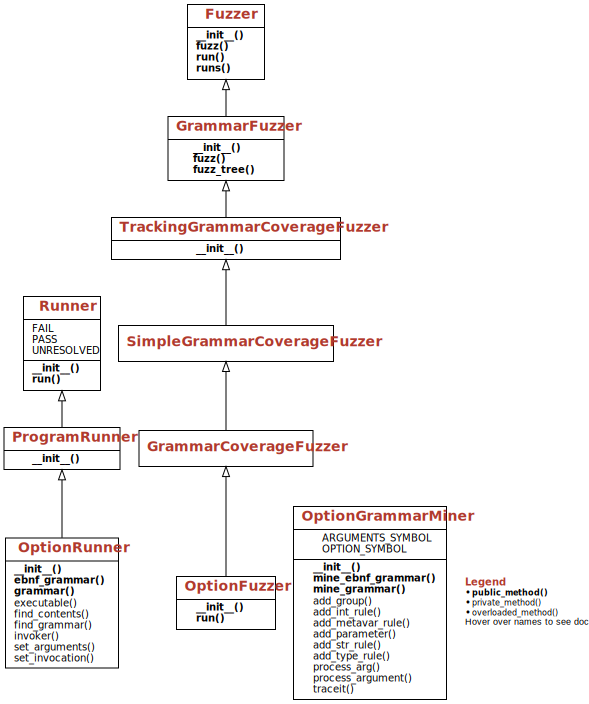

In [111]:
# ignore
display_class_hierarchy([OptionRunner, OptionFuzzer, OptionGrammarMiner],
                        public_methods=[
                            Fuzzer.__init__,
                            Fuzzer.fuzz,
                            Fuzzer.run,
                            Fuzzer.runs,
                            GrammarFuzzer.__init__,
                            GrammarFuzzer.fuzz,
                            GrammarFuzzer.fuzz_tree,
                            TrackingGrammarCoverageFuzzer.__init__,
                            OptionFuzzer.__init__,
                            OptionFuzzer.run,
                            Runner.__init__,
                            Runner.run,
                            ProgramRunner.__init__,
                            ProgramRunner.__init__,
                            OptionRunner.__init__,
                            OptionRunner.ebnf_grammar,
                            OptionRunner.grammar,
                            OptionGrammarMiner.__init__,
                            OptionGrammarMiner.mine_ebnf_grammar,
                            OptionGrammarMiner.mine_grammar,
                        ],
                        types={
                            'DerivationTree': DerivationTree,
                            'Expansion': Expansion,
                            'Grammar': Grammar
                        },
                        project='fuzzingbook')

## Lessons Learned

* Besides regular input data, program _configurations_ make an important testing target.
* For a given program using a standard library to parse command-line options and arguments, one can automatically extract these and convert them into a grammar.
* To cover not only single options, but combinations of options, one can expand the grammar to cover all pairs, or come up with even more ambitious targets.

## Next Steps

If you liked the idea of mining a grammar from a program, do not miss:

* [how to mine grammars for input data](GrammarMiner.ipynb)

Our next steps in the book focus on:

* [how to parse and recombine inputs](Parser.ipynb)
* [how to assign weights and probabilities to specific productions](ProbabilisticGrammarFuzzer.ipynb)
* [how to simplify inputs that cause a failure](Reducer.ipynb)

## Background

Although configuration data is just as likely to cause failures as other input data, it has received relatively little attention in test generation – possibly because, unlike "regular" input data, configuration data is not so much under control of external parties, and because, again unlike regular data, there is little variance in configurations.  Creating models for software configurations and using these models for testing is commonplace, as is the idea of pairwise testing.  For an overview, see \cite{Pezze2008}; for a discussion and comparison of state-of-the-art techniques, see \cite{Petke2015}.

More specifically, \cite{Sutton2007} also discuss techniques to systematically cover command-line options.  Dai et al. \cite{Dai2010} apply configuration fuzzing by changing variables associated with configuration files.  

## Exercises

### Exercise 1: #ifdef Configuration Fuzzing

In C programs, the *C preprocessor* can be used to choose which code parts should be compiled and which ones should not.  As an example, in the C code

```C
#ifdef LONG_FOO
long foo() { ... }
#else
int foo() { ... }
#endif
```

the compiler will compile the function `foo()` with return type`long` if the _preprocessor variable_ `LONG_FOO` is defined, and with return type `int` if not.  Such preprocessor variables are either set in the source files (using `#define`, as in `#define LONG_FOO`) or on the C compiler command line (using `-D<variable>` or `-D<variable>=<value>`, as in `-DLONG_FOO`.

Such *conditional compilation* is used to configure C programs towards their environment.  System-specific code can contain lots of conditional compilation.  As an example, consider this excerpt of `xmlparse.c`, the XML parser that is part of the Python runtime library:

```c
#if defined(_WIN32) && !defined(LOAD_LIBRARY_SEARCH_SYSTEM32)
# define LOAD_LIBRARY_SEARCH_SYSTEM32  0x00000800
#endif

#if !defined(HAVE_GETRANDOM) && !defined(HAVE_SYSCALL_GETRANDOM) \
    && !defined(HAVE_ARC4RANDOM_BUF) && !defined(HAVE_ARC4RANDOM) \
    && !defined(XML_DEV_URANDOM) \
    && !defined(_WIN32) \
    && !defined(XML_POOR_ENTROPY)
# error
#endif

#if !defined(TIOCSWINSZ) || defined(__SCO__) || defined(__UNIXWARE__)
#define USE_SYSV_ENVVARS	/* COLUMNS/LINES vs. TERMCAP */
#endif

#ifdef XML_UNICODE_WCHAR_T
#define XML_T(x) (const wchar_t)x
#define XML_L(x) L ## x
#else
#define XML_T(x) (const unsigned short)x
#define XML_L(x) x
#endif

int fun(int x) { return XML_T(x); }
```

A typical configuration for the C preprocessor on the above code could be `cc -c -D_WIN32 -DXML_POOR_ENTROPY -DXML_UNICODE_WCHAR_T xmlparse.c`, defining the given preprocessor variables and selecting the appropriate code fragments.

Since the compiler can only compile one configuration at a time (implying that we can also only _test_ one resulting executable at a time), your task is to find out which of these configurations actually compile.  To this end, proceed in three steps.

#### Part 1: Extract Preprocessor Variables

Write a _function_ `cpp_identifiers()` that, given a set of lines (say, from `open(filename).readlines()`), extracts all preprocessor variables referenced in `#if` or `#ifdef` preprocessor instructions.  Apply `ifdef_identifiers()` on the sample C input above, such that

```python
cpp_identifiers(open("xmlparse.c").readlines()) 
```

returns the set

```python
{'_WIN32', 'LOAD_LIBRARY_SEARCH_SYSTEM32', 'HAVE_GETRANDOM', 'HAVE_SYSCALL_GETRANDOM', 'HAVE_ARC4RANDOM_BUF', ...}

```

**Solution.**  Let us start with creating a sample input file, `xmlparse.c`:

In [112]:
filename = "xmlparse.c"

In [113]:
open(filename, "w").write(
    """
#if defined(_WIN32) && !defined(LOAD_LIBRARY_SEARCH_SYSTEM32)
# define LOAD_LIBRARY_SEARCH_SYSTEM32  0x00000800
#endif

#if !defined(HAVE_GETRANDOM) && !defined(HAVE_SYSCALL_GETRANDOM) \
    && !defined(HAVE_ARC4RANDOM_BUF) && !defined(HAVE_ARC4RANDOM) \
    && !defined(XML_DEV_URANDOM) \
    && !defined(_WIN32) \
    && !defined(XML_POOR_ENTROPY)
# error
#endif

#if !defined(TIOCSWINSZ) || defined(__SCO__) || defined(__UNIXWARE__)
#define USE_SYSV_ENVVARS	/* COLUMNS/LINES vs. TERMCAP */
#endif

#ifdef XML_UNICODE_WCHAR_T
#define XML_T(x) (const wchar_t)x
#define XML_L(x) L ## x
#else
#define XML_T(x) (const unsigned short)x
#define XML_L(x) x
#endif

int fun(int x) { return XML_T(x); }
""");

To find C preprocessor `#if` directives and preprocessor variables, we use regular expressions matching them.

In [114]:
import re

In [115]:
re_cpp_if_directive = re.compile(r"\s*#\s*(el)?if")
re_cpp_identifier = re.compile(r"[a-zA-Z_$]+")

In [116]:
def cpp_identifiers(lines):
    identifiers = set()
    for line in lines:
        if re_cpp_if_directive.match(line):
            identifiers |= set(re_cpp_identifier.findall(line))

    # These are preprocessor keywords
    identifiers -= {"if", "ifdef", "ifndef", "defined"}
    return identifiers

In [117]:
cpp_ids = cpp_identifiers(open("xmlparse.c").readlines())
cpp_ids

{'HAVE_ARC',
 'HAVE_GETRANDOM',
 'HAVE_SYSCALL_GETRANDOM',
 'LOAD_LIBRARY_SEARCH_SYSTEM',
 'RANDOM',
 'RANDOM_BUF',
 'TIOCSWINSZ',
 'XML_DEV_URANDOM',
 'XML_POOR_ENTROPY',
 'XML_UNICODE_WCHAR_T',
 '_WIN',
 '__SCO__',
 '__UNIXWARE__'}

#### Part 2: Derive an Option Grammar

With the help of `cpp_identifiers()`, create a grammar which has C compiler invocations with a list of options, where each option takes the form `-D<variable>` for a preprocessor variable `<variable>`.  Using this grammar `cpp_grammar`, a fuzzer 

```python
g = GrammarCoverageFuzzer(cpp_grammar)
```

would create C compiler invocations such as

```python
[g.fuzz() for i in range(10)]
['cc -DHAVE_SYSCALL_GETRANDOM xmlparse.c',
 'cc -D__SCO__ -DRANDOM_BUF -DXML_UNICODE_WCHAR_T -D__UNIXWARE__ xmlparse.c',
 'cc -DXML_POOR_ENTROPY xmlparse.c',
 'cc -DRANDOM xmlparse.c',
 'cc -D_WIN xmlparse.c',
 'cc -DHAVE_ARC xmlparse.c', ...]
```

**Solution.** This is not very difficult:

In [118]:
from Grammars import Grammar, is_valid_grammar

In [119]:
cpp_grammar: Grammar = {
    "<start>": ["cc -c<options> " + filename],
    "<options>": ["<option>", "<options><option>"],
    "<option>": []
}

for id in cpp_ids:
    s = new_symbol(cpp_grammar, "<" + id + ">")
    cpp_grammar["<option>"].append(s)
    cpp_grammar[s] = [" -D" + id]

assert is_valid_grammar(cpp_grammar)

In [120]:
cpp_grammar

{'<start>': ['cc -c<options> xmlparse.c'],
 '<options>': ['<option>', '<options><option>'],
 '<option>': ['<XML_UNICODE_WCHAR_T>',
  '<XML_DEV_URANDOM>',
  '<XML_POOR_ENTROPY>',
  '<__UNIXWARE__>',
  '<RANDOM_BUF>',
  '<LOAD_LIBRARY_SEARCH_SYSTEM>',
  '<HAVE_ARC>',
  '<__SCO__>',
  '<HAVE_SYSCALL_GETRANDOM>',
  '<HAVE_GETRANDOM>',
  '<_WIN>',
  '<RANDOM>',
  '<TIOCSWINSZ>'],
 '<XML_UNICODE_WCHAR_T>': [' -DXML_UNICODE_WCHAR_T'],
 '<XML_DEV_URANDOM>': [' -DXML_DEV_URANDOM'],
 '<XML_POOR_ENTROPY>': [' -DXML_POOR_ENTROPY'],
 '<__UNIXWARE__>': [' -D__UNIXWARE__'],
 '<RANDOM_BUF>': [' -DRANDOM_BUF'],
 '<LOAD_LIBRARY_SEARCH_SYSTEM>': [' -DLOAD_LIBRARY_SEARCH_SYSTEM'],
 '<HAVE_ARC>': [' -DHAVE_ARC'],
 '<__SCO__>': [' -D__SCO__'],
 '<HAVE_SYSCALL_GETRANDOM>': [' -DHAVE_SYSCALL_GETRANDOM'],
 '<HAVE_GETRANDOM>': [' -DHAVE_GETRANDOM'],
 '<_WIN>': [' -D_WIN'],
 '<RANDOM>': [' -DRANDOM'],
 '<TIOCSWINSZ>': [' -DTIOCSWINSZ']}

#### Part 3: C Preprocessor Configuration Fuzzing

Using the grammar just produced, use a `GrammarCoverageFuzzer` to

1. Test each processor variable individually
2. Test each pair of processor variables, using `pairwise()`.

What happens if you actually run the invocations?

**Solution.** We can simply run the coverage fuzzer, as described above.

In [121]:
g = GrammarCoverageFuzzer(cpp_grammar)
g.fuzz()

'cc -c -DTIOCSWINSZ -D__UNIXWARE__ xmlparse.c'

In [122]:
from Fuzzer import ProgramRunner

In [123]:
for i in range(10):
    invocation = g.fuzz()
    print("$", invocation)
    # subprocess.call(invocation, shell=True)
    cc_runner = ProgramRunner(invocation.split(' '))
    (result, outcome) = cc_runner.run()
    print(result.stderr, end="")

$ cc -c -D__SCO__ xmlparse.c
xmlparse.c:7:3: error: 
# error
  ^
1 error generated.
$ cc -c -DHAVE_SYSCALL_GETRANDOM xmlparse.c
$ cc -c -DXML_POOR_ENTROPY xmlparse.c
$ cc -c -DRANDOM_BUF -DHAVE_ARC xmlparse.c
xmlparse.c:7:3: error: 
# error
  ^
1 error generated.
$ cc -c -DHAVE_GETRANDOM -DLOAD_LIBRARY_SEARCH_SYSTEM -DXML_UNICODE_WCHAR_T xmlparse.c
xmlparse.c:22:25: error: expected ')'
int fun(int x) { return XML_T(x); }
                        ^
xmlparse.c:15:25: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                        ^
xmlparse.c:22:25: note: to match this '('
xmlparse.c:15:18: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                 ^
xmlparse.c:22:25: warning: type specifier missing, defaults to 'int' [-Wimplicit-int]
int fun(int x) { return XML_T(x); }
                        ^~~~~~~~
xmlparse.c:15:25: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                  ~~~~~ ^
1 warning and 1 error g

To test all pairs, we can use `pairwise()`:

In [124]:
pairwise_cpp_grammar = extend_grammar(cpp_grammar)
pairwise_cpp_grammar["<option>"] = pairwise(cpp_grammar["<option>"])
pairwise_cpp_grammar["<option>"][:10]

['<XML_UNICODE_WCHAR_T><XML_DEV_URANDOM>',
 '<XML_UNICODE_WCHAR_T><XML_POOR_ENTROPY>',
 '<XML_UNICODE_WCHAR_T><__UNIXWARE__>',
 '<XML_UNICODE_WCHAR_T><RANDOM_BUF>',
 '<XML_UNICODE_WCHAR_T><LOAD_LIBRARY_SEARCH_SYSTEM>',
 '<XML_UNICODE_WCHAR_T><HAVE_ARC>',
 '<XML_UNICODE_WCHAR_T><__SCO__>',
 '<XML_UNICODE_WCHAR_T><HAVE_SYSCALL_GETRANDOM>',
 '<XML_UNICODE_WCHAR_T><HAVE_GETRANDOM>',
 '<XML_UNICODE_WCHAR_T><_WIN>']

In [125]:
for i in range(10):
    invocation = g.fuzz()
    print("$", invocation)
    # subprocess.call(invocation, shell=True)
    cc_runner = ProgramRunner(invocation.split(' '))
    (result, outcome) = cc_runner.run()
    print(result.stderr, end="")

$ cc -c -D__UNIXWARE__ xmlparse.c
xmlparse.c:7:3: error: 
# error
  ^
1 error generated.
$ cc -c -DHAVE_GETRANDOM -DXML_POOR_ENTROPY -DRANDOM -DHAVE_ARC xmlparse.c
$ cc -c -D__SCO__ xmlparse.c
xmlparse.c:7:3: error: 
# error
  ^
1 error generated.
$ cc -c -DRANDOM -DXML_UNICODE_WCHAR_T -D_WIN xmlparse.c
xmlparse.c:7:3: error: 
# error
  ^
xmlparse.c:22:25: error: expected ')'
int fun(int x) { return XML_T(x); }
                        ^
xmlparse.c:15:25: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                        ^
xmlparse.c:22:25: note: to match this '('
xmlparse.c:15:18: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                 ^
xmlparse.c:22:25: warning: type specifier missing, defaults to 'int' [-Wimplicit-int]
int fun(int x) { return XML_T(x); }
                        ^~~~~~~~
xmlparse.c:15:25: note: expanded from macro 'XML_T'
#define XML_T(x) (const wchar_t)x
                  ~~~~~ ^
1 warning and 2 errors generated.

Some of the compilation errors we get could be expected – for instance, defining `XML_UNICODE_WCHAR_T` when actually, the type is not supported in our environment.  Other errors may not be expected – and it is these errors we would find through systematic configuration fuzzing, as described above.

At the end, don't forget to clean up:

In [126]:
os.remove("xmlparse.c")

In [127]:
if os.path.exists("xmlparse.o"):
    os.remove("xmlparse.o")

### Exercise 2: .ini Configuration Fuzzing

Besides command-line options, another important source of configurations are _configuration files_.  In this exercise, we will consider the very simple configuration language provided by the Python `ConfigParser` module, which is very similar to what is found in Microsoft Windows _.ini_ files.

The following example for a `ConfigParser` input file stems right from [the ConfigParser documentation](https://docs.python.org/3/library/configparser.html):
```
[DEFAULT]
ServerAliveInterval = 45
Compression = yes
CompressionLevel = 9
ForwardX11 = yes

[bitbucket.org]
User = hg

[topsecret.server.com]
Port = 50022
ForwardX11 = no
```

The above `ConfigParser` file can be created programmatically:

In [128]:
import configparser

In [129]:
config = configparser.ConfigParser()
config['DEFAULT'] = {'ServerAliveInterval': '45',
                     'Compression': 'yes',
                     'CompressionLevel': '9'}
config['bitbucket.org'] = {}
config['bitbucket.org']['User'] = 'hg'
config['topsecret.server.com'] = {}
topsecret = config['topsecret.server.com']
topsecret['Port'] = '50022'     # mutates the parser
topsecret['ForwardX11'] = 'no'  # same here
config['DEFAULT']['ForwardX11'] = 'yes'
with open('example.ini', 'w') as configfile:
    config.write(configfile)

with open('example.ini') as configfile:
    print(configfile.read(), end="")

[DEFAULT]
serveraliveinterval = 45
compression = yes
compressionlevel = 9
forwardx11 = yes

[bitbucket.org]
user = hg

[topsecret.server.com]
port = 50022
forwardx11 = no



and be read in again:

In [130]:
config = configparser.ConfigParser()
config.read('example.ini')
topsecret = config['topsecret.server.com']
topsecret['Port']

'50022'

#### Part 1: Read Configuration

Using `configparser`, create a program reading in the above configuration file and accessing the individual elements.

#### Part 2: Create a Configuration Grammar

Design a grammar that will automatically create configuration files suitable for your above program.  Fuzz your program with it.

#### Part 3: Mine a Configuration Grammar

By dynamically tracking the individual accesses to configuration elements, you can again extract a basic grammar from the execution.  To this end, create a subclass of `ConfigParser` with a special method `__getitem__`:

In [131]:
class TrackingConfigParser(configparser.ConfigParser):
    def __getitem__(self, key):
        print("Accessing", repr(key))
        return super().__getitem__(key)

For a `TrackingConfigParser` object `p`, `p.__getitem__(key)` will be invoked whenever `p[key]` is accessed:

In [132]:
tracking_config_parser = TrackingConfigParser()
tracking_config_parser.read('example.ini')
section = tracking_config_parser['topsecret.server.com']

Accessing 'topsecret.server.com'


Using `__getitem__()`, as above, implement a tracking mechanism that, while your program accesses the read configuration, automatically saves options accessed and values read.  Create a prototype grammar from these values; use it for fuzzing.

At the end, don't forget to clean up:

In [133]:
import os

In [134]:
os.remove("example.ini")

**Solution.** Left to the reader.  Enjoy!

### Exercise 3: Extracting and Fuzzing C Command-Line Options

In C programs, the `getopt()` function are frequently used to process configuration options.  A call

```
getopt(argc, argv, "bf:")
```

indicates that the program accepts two options `-b` and `-f`, with `-f` taking an argument (as indicated by the following colon).

#### Part 1: Getopt Fuzzing

Write a framework which, for a given C program, automatically extracts the argument to `getopt()` and derives a fuzzing grammar for it.  There are multiple ways to achieve this:

1. Scan the program source code for occurrences of `getopt()` and return the string passed.  (Crude, but should frequently work.)
2. Insert your own implementation of `getopt()` into the source code (effectively replacing `getopt()` from the runtime library), which outputs the `getopt()` argument and exits the program.  Recompile and run.
3. (Advanced.) As above, but instead of changing the source code, hook into the _dynamic linker_ which at runtime links the program with the C runtime library.  Set the library loading path (on Linux and Unix, this is the `LD_LIBRARY_PATH` environment variable) such that your own version of `getopt()` is linked first, and the regular libraries later.  Executing the program (without recompiling) should yield the desired result.

Apply this on `grep` and `ls`; report the resulting grammars and results.

**Solution.** Left to the reader.  Enjoy hacking!

#### Part 2: Fuzzing Long Options in C

Same as Part 1, but also hook into the GNU variant `getopt_long()`, which accepts "long" arguments with double dashes such as `--help`.  Note that method 1, above, will not work here, since the "long" options are defined in a separately defined structure.

**Solution.** Left to the reader.  Enjoy hacking!

### Exercise 4: Expansions in Context

In our above option configurations, we have multiple symbols which all expand to the same integer.  For instance, the `--line-range` option of `autopep8` takes two `<line>` parameters which both expand into the same `<int>` symbol:

```
<option> ::= ... | --line-range <line> <line> | ...
<line> ::= <int>
<int> ::= (-)?<digit>+
<digit> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
```

In [135]:
autopep8_runner.ebnf_grammar()["<line>"]

['<int>']

In [136]:
autopep8_runner.ebnf_grammar()["<int>"]

['(-)?<digit>+']

In [137]:
autopep8_runner.ebnf_grammar()["<digit>"]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Once the `GrammarCoverageFuzzer` has covered all variations of `<int>` (especially by covering all digits) for _one_ option, though, it will no longer strive to achieve such coverage for the next option.  Yet, it could be desirable to achieve such coverage for each option separately.

One way to achieve this with our existing `GrammarCoverageFuzzer` is again to change the grammar accordingly.  The idea is to _duplicate_ expansions – that is, to replace an expansion of a symbol $s$ with a new symbol $s'$ whose definition is duplicated from $s$.  This way, $s'$ and $s$ are separate symbols from a coverage point of view and would be independently covered.

As an example, consider again the above `--line-range` option.  If we want our tests to independently cover all elements of the two `<line>` parameters, we can duplicate the second `<line>` expansion into a new symbol `<line'>` with subsequent duplicated expansions:
```
<option> ::= ... | --line-range <line> <line'> | ...
<line> ::= <int>
<line'> ::= <int'>
<int> ::= (-)?<digit>+
<int'> ::= (-)?<digit'>+
<digit> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
<digit'> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9
```

Design a function `inline(grammar, symbol)` that returns a duplicate of `grammar` in which every occurrence of `<symbol>` and its expansions become separate copies.  The above grammar could be a result of `inline(autopep8_runner.ebnf_grammar(), "<line>")`.

When copying, expansions in the copy should also refer to symbols in the copy.  Hence, when expanding `<int>` in

```<int> ::= <int><digit>```

make that

```<int> ::= <int><digit>
<int'> ::= <int'><digit'>
```

(and not `<int'> ::= <int><digit'>` or `<int'> ::= <int><digit>`).

Be sure to add precisely one new set of symbols for each occurrence in the original grammar, and not to expand further in the presence of recursion.

**Solution.** Again, left to the reader.  Enjoy!